# Create the grid for WHETGEO-1D Richards
## Srivastava Yeh analytical solution layered soil wetting case
    -Author: Niccolò Tubini and Riccardo Rigon
    -License: this work is licensed under a Creative Commons Attribution-NonCommercial 4.0 International License
-----
This notebook is used to create the computational grid
    - domain discretization
    - setting parameters
    - setting initial condition
for the analytical solution presented by [Srivastava and Yeh (1991)](https://doi.org/10.1029/90WR02772) for the case of homogeneous layer.

    
All grid data are stored in a NetCDF file.


In [1]:
%load_ext autoreload
%autoreload 2

import os
import pandas as pd

from WHETGEO1D_GridCreator import*
from WHETGEO1D_toNetCDF import*
from Srivastava_Yeh_1991_analytical_solution import *

import warnings
warnings.filterwarnings('ignore')


project_path = os.path.dirname(os.getcwd())


## Define input:
**grid_input_file_name**: name of the grid input file (.csv) with the local file path 
   
> `/data/Grid_input/name.csv`

**ic_input_file_name**: name of the initial condition input file (.csv) with the local file path 
> `/data/Grid_input/name.csv`

**parameter_input_file_name**: name of the parameter input file (.csv) with the local file path 
>`/data/Grid_input/name.csv`

**dictionary_input_file_name**: name of the file (.csv) containing the dictionary for parameters name 
>`/data/Grid_input/name.csv`

**grid_type**: string defining how to discretize the 1D domain. You can choose among:
> `classical`

> `exponential`

> `mixed` 


**dz_min**: thickness of the first layer (for `exponential` and `mixed`)

**dz_max**: larger thickness of the grid (for `mixed`)

**b**: growth rate (for `exponential` and `mixed`)

**psi_interp_model**: string defining the type of the 1D interpolation function used to define the initial condition for water suction 
> https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html#scipy.interpolate.interp1d 

**T_interp_model**: string defining the type of the 1D interpolation function used to define the initial condition for temperature
>https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html#scipy.interpolate.interp1d 


<br />
<br />

**output_file_name**: name of the output file (.nc) with the local file path
>`/data/Grid_NetCDF/name.nc`

**output_title**: string containing a title for the output, it is saved within the file

**output_summary**: string containing a description for the output, it is saved within the file (global metadata)

**output_date**: string containing the date of file creation, optionally

**output_institution**: string containing the name of whom created the file, optionally



In [2]:
grid_input_file_name = project_path + "/data/Grid_input/SrivastavaYeh_layered_grid.csv"

parameter_input_file_name = project_path + "/data/Grid_input/SrivastavaYeh_layered_parameter.csv"

dictionary_input_file_name = project_path + "/data/Grid_input/dictionary.csv"

grid_type = 'classical'

dz_min = np.nan

dz_max = np.nan

b = np.nan

# psi_interp_model = "linear"

# T_interp_model = "linear"



output_file_name = project_path + "/data/Grid_NetCDF/SrivastavaYeh_layered_Set2_wetting.nc"

output_title = '''Srivastava and Yeh (1991) layered soil wetting case.'''
output_summary = '''

L1_star = 100 # cm
L2_star = 100
Ks1 = 10
Ks2 = 1
alpha1 = 0.1
alpha2 = 0.1
theta_s1 = 0.4
theta_r1 = 0.06
theta_s2 = 0.4
theta_r2 = 0.06
qA1_star = 0.1
qA2_star = 0.1
qB1_star = 0.9
qB2_star = 0.9
NMAX = 1001
psi0 = 0

'''

output_date = ''

output_institution = 'Niccolò Tubini, Riccardo Rigon, GEOframe group'

# Srivastava Yeh parameter for layerd soil wetting case
L1_star = 100 # cm
L2_star = 100
Ks1 = 10
Ks2 = 1
alpha1 = 0.1
alpha2 = 0.1
theta_s1 = 0.4
theta_r1 = 0.06
theta_s2 = 0.4
theta_r2 = 0.06
qA1_star = 0.1
qA2_star = 0.1
qB1_star = 0.9
qB2_star = 0.9
NMAX = 1001
psi0 = 0

## Run

In [3]:
L1 = L1_star*alpha1 # cm
L2 = L2_star*alpha2
qA1 = qA1_star/Ks1
qA2 = qA2_star/Ks2
qB1 = qB1_star/Ks1
qB2 = qB2_star/Ks2
# z1 = z1_star*alpha1
# z2 = z2_star*alpha2
beta = (alpha1*Ks1*(theta_s2-theta_r2))/(alpha2*Ks2*(theta_s1-theta_r1))


data_grid = pd.read_csv(grid_input_file_name)
print('Grid')
print(data_grid)
print()

data_parameter = pd.read_csv(parameter_input_file_name, comment='#')
print('Parameter')
print(data_parameter)
print()

data_dictionary = pd.read_csv(dictionary_input_file_name)

[KMAX, eta, eta_dual, space_delta, z, z_dual, control_volume] = grid1D(data_grid, dz_min, b, dz_max, grid_type)

z1 = (z[z<L1_star*1e-2]*1e2-L1_star)*alpha1
K1_0 = qA1-(qA1-np.exp(alpha1*0))*np.exp(-L1-z1)
psi1_0 = 1/alpha1*np.log(K1_0)

z2 = (z[z>L1_star*1e-2]*1e2-L1_star)*alpha2
K2_0 = qA2 - (qA2 - (qA1 - (qA1-np.exp(alpha1*0))*np.exp(-L1))**(alpha2/alpha1))*np.exp(-z2)
psi2_0 = 1/alpha2*np.log(K2_0)

psi_0 = np.concatenate([psi1_0,psi2_0])*1e-2
T_0 = np.zeros(len(psi_0))

control_volume_index = calibration_point_index(data_grid, eta)

[equation_state_ID, parameter_ID, theta_s, theta_r, par_1, par_2, par_3, par_4,
par_5, alpha_ss, beta_ss, ks] = set_parameters_richards(data_grid, data_parameter, data_dictionary, KMAX, eta)

write_grid_netCDF_richards(eta, eta_dual, z, z_dual, space_delta, control_volume, control_volume_index, psi_0, T_0, equation_state_ID, parameter_ID, KMAX,
                  theta_s, theta_r, par_1, par_2, par_3, par_4, par_5, alpha_ss, beta_ss, ks,
                  output_file_name, output_title, output_institution, output_summary, output_date, grid_input_file_name, parameter_input_file_name)

Grid
  Type  eta       K  equationStateID  parameterID
0    L    0  1000.0              0.0          2.0
1    L   -1  1000.0              0.0          1.0
2    L   -2     NaN              NaN          NaN

Parameter
   thetaS  thetaR  par1  par2  par3  par4  par5  alphaSpecificStorage  \
0     0.4    0.06    10   NaN   NaN   NaN   NaN                   0.0   
1     0.4    0.06    10   NaN   NaN   NaN   NaN                   0.0   

   betaSpecificStorage        Ks  
0                  0.0  0.000028  
1                  0.0  0.000003  



***SUCCESS writing!  C:\Users\Niccolo\OMS\OMS_Project_WHETGEO1D/data/Grid_NetCDF/SrivastavaYeh_layered_Set2_wetting.nc


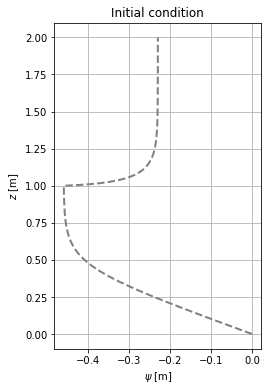

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(6/1.618, 6)) 

ax.plot(psi_0, z, color='0.5', linewidth=2, linestyle='--', label='ic')

ax.set_xlabel('$\psi$ [m]')
ax.set_ylabel('$z$ [m]')
ax.set_title('Initial condition')

ax.grid()

plt.show()